## Chapter 12, ML Engineering in Action
<b><i>Author: Ben Wilson</i></b><br>
In this notebook, we're following along with Chapter 12, "Model measurement and why it's so important".
We're focusing mostly on attribution analysis, statistical testing, and drift detection in this notebook.

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from collections import namedtuple
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, wilcoxon, kruskal, friedmanchisquare, fisher_exact, chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats import anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import tt_ind_solve_power

Static values that will be used throughout for synthetic data generators

In [2]:
# Static values for the script
DATE_START = datetime(2020,12,1)
DATA_SIZE = 260
DATE_FIELD = 'Date'
TARGET_FIELD = 'Sales'
TEST_FIELD = 'Test'

# Generate the simulated temperature data
np.random.seed(42)
_base_temp = np.random.lognormal(mean=2.0, sigma=0.42, size=DATA_SIZE)
_seasonal = [np.polyval([-5,0,-1], x) for x in np.linspace(start=0, stop=2, num=DATA_SIZE)]
temperature = np.linspace(start=45.0, stop=90.0, num=DATA_SIZE) + _base_temp + _seasonal
date_ranges = np.arange(DATE_START, 
                        DATE_START + timedelta(days=DATA_SIZE), 
                        timedelta(days=1)).astype(date)

Some statistical test wrappers

In [3]:
def calculate_basic_stats(series):
    StatsData = namedtuple('StatsData', 'name mean median stddev variance sum')
    return StatsData(series.name,
                     np.mean(series.data),
                     np.median(series.data),
                     np.std(series.data),
                     np.var(series.data),
                     np.sum(series.data)
                    )

def series_comparison_continuous(a, b):
    BatteryData = namedtuple('BatteryData', 'left right anova mann_whitney_u wilcoxon ttest')
    TestData = namedtuple('TestData', 'statistic pvalue')
    anova_test = f_oneway(a.data, b.data)
    mann_whitney = mannwhitneyu(a.data, b.data)
    wilcoxon_rank = wilcoxon(a.data, b.data)
    t_test = ttest_ind(a.data, b.data, equal_var=False)
    return BatteryData(a.name, 
                       b.name, 
                       TestData(anova_test.statistic, anova_test.pvalue),
                       TestData(mann_whitney.statistic, mann_whitney.pvalue),
                       TestData(wilcoxon_rank.statistic, wilcoxon_rank.pvalue),
                       TestData(t_test.statistic, t_test.pvalue)
                      )

def calculate_basic_stats_df(series):
    StatsData = namedtuple('StatsData', 'name mean median stddev variance sum')
    return StatsData(series.name,
                     np.mean(series),
                     np.median(series),
                     np.std(series),
                     np.var(series),
                     np.sum(series)
                    )

def series_comparison_continuous_df(a, b):
    BatteryData = namedtuple('BatteryData', 'left right anova mann_whitney_u wilcoxon ttest')
    TestData = namedtuple('TestData', 'statistic pvalue')
    anova_test = f_oneway(a, b)
    mann_whitney = mannwhitneyu(a, b)
    wilcoxon_rank = wilcoxon(a, b)
    t_test = ttest_ind(a, b, equal_var=False)
    return BatteryData(a.name, 
                       b.name, 
                       TestData(anova_test.statistic, anova_test.pvalue),
                       TestData(mann_whitney.statistic, mann_whitney.pvalue),
                       TestData(wilcoxon_rank.statistic, wilcoxon_rank.pvalue),
                       TestData(t_test.statistic, t_test.pvalue)
                      )

def multi_series_equivalency(series):
    series_data = [x.data for x in series]
    StatResults = namedtuple('StatResults', 'kruskal friedman')
    kruskal_test = kruskal(*series_data)
    friedman_test = friedmanchisquare(*series_data)
    return StatResults(kruskal_test, friedman_test)

Some data manipulation functions (mostly converting our numpy Series data to Pandas) and data generation elements

In [4]:
def prevent_negatives(series):
    return [0.0 if x < 0.0 else x for x in series]

def generate_series(base_start, base_end, variance_mu, variance_sigma, group_name, data_size=DATA_SIZE):
    Test_Series = namedtuple('Test_Series', 'name data start stop mu sigma')
    noise_factor = np.random.normal(variance_mu, variance_sigma, data_size)
    generated = np.linspace(start=base_start, stop=base_end, num=data_size) + noise_factor
    return Test_Series(group_name, prevent_negatives(generated), base_start, base_end, variance_mu, variance_sigma)

def generate_data(config):
    series_gen = []
    for k, v in config.items():
        for pk, pv in v.items():
            generated = generate_series(pv['start'], pv['stop'], pv['mu'], pv['sigma'], "{}_{}".format(pk, k))
            series_gen.append(generated)
    return series_gen

def generate_df(series_collection, dates):
    series_df = pd.DataFrame.from_records([x.data for x in series_collection]).T
    series_df.columns = [x.name for x in series_collection]
    series_df[DATE_FIELD] = dates
    return series_df

def generate_melted_df(series_collection, dates, date_filtering=DATA_SIZE):
    series_df = generate_df(series_collection, dates)
    melted = pd.melt(series_df.reset_index(), id_vars='Date', value_vars=[x.name for x in series_collection])
    melted.columns = [DATE_FIELD, 'Test', 'Sales']
    return melted[melted[DATE_FIELD] > max(melted[DATE_FIELD]) - timedelta(days=date_filtering)]

def generate_augmented_df(series_data):
    our_data_df = generate_df(series_data, date_ranges)
    for i in ['High', 'Medium', 'Low']:
        our_data_df['{}_Value_Sales'.format(i)] = (
            our_data_df['Control_{}_Value'.format(i)] + our_data_df['Test_{}_Value'.format(i)])
    our_data_df['Control_Sales'] = (
        our_data_df['Control_High_Value'] + 
        our_data_df['Control_Medium_Value'] + 
        our_data_df['Control_Low_Value'])
    our_data_df['Test_Sales'] = (
        our_data_df['Test_High_Value'] + 
        our_data_df['Test_Medium_Value'] + 
        our_data_df['Test_Low_Value'])
    our_data_df['Total_Sales'] = our_data_df['Control_Sales'] + our_data_df['Test_Sales']
    return our_data_df

def filter_augmented_start(data, days_forward=30):
    return data[data[DATE_FIELD] < min(data[DATE_FIELD]) + timedelta(days=days_forward)]

def filter_augmented_latest(data, days_back=30):
    return data[data[DATE_FIELD] > max(data[DATE_FIELD]) - timedelta(days=days_back)]

def extract_data(result_data, index, data_type):
    return pd.Series([x[index] for x in result_data], dtype=np.dtype(data_type))

def convert_tukey_to_df(tukey):
    STRUCTURES = [(0, 'str'), (1, 'str'), (2, 'float'), (3, 'float'), (4, 'float'), (5, 'float'), (6, 'bool')]
    fields = tukey.data[0]
    extracts = [extract_data(tukey.data[1:], x[0], x[1]) for x in STRUCTURES]
    result_df = pd.concat(extracts, axis=1)
    result_df.columns = fields
    return result_df.sort_values(['p-adj', 'meandiff'], ascending=[True, False])

def run_anova(data, value_name, group_name):
    ols_model = ols('{} ~ C({})'.format(value_name, group_name), data=data).fit()
    return anova.anova_lm(ols_model, typ=2)

def run_tukey(value, group, alpha=0.05):
    paired_test = pairwise_tukeyhsd(value, group, alpha)
    return convert_tukey_to_df(paired_test._results_table)

Some plotting functions

In [5]:
def plot_corr(x, y, x_name, y_name, size=(10,10)):
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=size)
        ax = fig.add_subplot(111)
        ax.scatter(x, y)
        ax.set_title("Correlation of {} and {}".format(x_name, y_name))
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.plot(np.unique(x), 
                np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
                color='darkred', 
                label='linear fit')
        ax.plot(np.unique(x), 
                np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), 
                color='green', 
                label='2nd degree polynomial fit', 
                linestyle='--')
        ax.text(min(x), min(y),"Correlation coefficient: {}".format(np.corrcoef(x,y)[0][1]))
        ax.legend(loc='best')
        plt.tight_layout()
        plt.savefig("{}_{}_correlation.svg".format(x_name, y_name), format='svg')

def plot_comparison_series_df(x, y1, y2, name, size=(10,10)):
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=size)
        ax = fig.add_subplot(111)
        ax.plot(x, y1, color='darkred', label=y1.name)
        ax.plot(x, y2, color='green', label=y2.name)
        ax.set_title("Comparison of Sales between tests {} and {}".format(y1.name, y2.name))
        ax.set_xlabel(DATE_FIELD)
        ax.set_ylabel(TARGET_FIELD)
        comparison = series_comparison_continuous_df(y1, y2)
        y1_stats = calculate_basic_stats_df(y1)
        y2_stats = calculate_basic_stats_df(y2)
        bbox_stats = "\n".join((
            "Series {}:".format(y1.name),
            "   Mean: {:.2f}".format(y1_stats.mean),
            "   Median: {:.2f}".format(y1_stats.median),
            "   Stddev: {:.2f}".format(y1_stats.stddev),
            "   Variance: {:.2f}".format(y1_stats.variance),
            "   Sum: {:.2f}".format(y1_stats.sum),
            "Series {}:".format(y2.name),
            "   Mean: {:.2f}".format(y2_stats.mean),
            "   Median: {:.2f}".format(y2_stats.median),
            "   Stddev: {:.2f}".format(y2_stats.stddev),
            "   Variance: {:.2f}".format(y2_stats.variance),
            "   Sum: {:.2f}".format(y2_stats.sum)
        ))
        bbox_text = "Anova pvalue: {}\nT-test pvalue: {}\nMannWhitneyU pvalue: {}\nWilcoxon pvalue: {}".format(
            comparison.anova.pvalue,
            comparison.ttest.pvalue,
            comparison.mann_whitney_u.pvalue,
            comparison.wilcoxon.pvalue
        )
        bbox_props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)
        ax.text(0.05, 0.95, bbox_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=bbox_props)
        ax.text(0.05, 0.8, bbox_stats, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)
        ax.legend(loc='lower right')
        plt.tight_layout()    
        plt.savefig('time_series_{}.svg'.format(name), format='svg')
        
def plot_anova(melted_data, plot_name, figsize=(16, 16)):
    anova_report = run_anova(melted_data, 'Sales', 'Test')
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=figsize)
        ax0 = fig.add_subplot(111)
        ax0 = sns.boxplot(x='Test', y='Sales', data=melted_data, color='lightsteelblue')
        ax0 = sns.stripplot(x='Test', y='Sales', data=melted_data, color='steelblue', alpha=0.4, jitter=0.2)
        ax1 = fig.add_subplot(211)
        ax1.set_title("Anova Analysis of tests", y=1.25, fontsize=16)
        tbl = ax1.table(cellText=anova_report.values, 
                        colLabels=anova_report.columns, 
                        rowLabels=anova_report.index, 
                        loc='top', 
                        cellLoc='center', 
                        rowLoc='center',
                        bbox=[0.075,1.0,0.875,0.2]
                       )
        tbl.auto_set_column_width(col=list(range(len(anova_report.columns))))
        ax1.axis('tight')
        ax1.set_axis_off()
        ax0.tick_params(axis='x', rotation=45)
        plt.savefig("anova_{}.svg".format(plot_name), format='svg')

def plot_tukey(melted_data, name, alpha=0.05, figsize=(14,14)):
    tukey_data = run_tukey(melted_data[TARGET_FIELD], melted_data[TEST_FIELD], alpha)
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=figsize)
        ax_plot = fig.add_subplot(111)
        ax_plot = sns.boxplot(x=TEST_FIELD, y=TARGET_FIELD, data=melted_data, color='lightsteelblue')
        ax_plot = sns.stripplot(x=TEST_FIELD, y=TARGET_FIELD, 
                                data=melted_data, color='steelblue', alpha=0.4, jitter=0.2)
        ax_table = fig.add_subplot(211)
        ax_table.set_title("TukeyHSD Analysis of tests", y=1.5, fontsize=16)
        tbl = ax_table.table(cellText = tukey_data.values,
                             colLabels = tukey_data.columns,
                             rowLabels = tukey_data.index,
                             loc='top',
                             cellLoc='center',
                             rowLoc='center',
                             bbox=[0.075, 1.0, 0.875, 0.5]
                            )
        tbl.auto_set_column_width(col=list(range(len(tukey_data.columns))))
        ax_table.axis('tight')
        ax_table.set_axis_off()
        plt.tight_layout()
        plt.savefig('tukey_{}.svg'.format(name), format='svg')

def plot_equivalency_series(x, y, plot_name, size=(10,10)):
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=size)
        ax = fig.add_subplot(111)
        [ax.plot(x, z.data, label=z.name) for z in y]
        ax.set_title("Comparison of Sales")
        ax.set_xlabel(DATE_FIELD)
        ax.set_ylabel(TARGET_FIELD)
        comparison = multi_series_equivalency(y)
        bbox_text = "Kruskal pvalue: {}\nFriedman Chisq pvalue: {}".format(
            comparison.kruskal.pvalue,
            comparison.friedman.pvalue
        )
        bbox_props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)
        ax.text(0.05, 0.95, bbox_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=bbox_props)
        ax.legend(loc='lower right')
        plt.tight_layout()  
        plt.savefig('equivalency_test_{}.svg'.format(plot_name), format='svg')
        
def plot_single_series(data, y_field, y_name, y_label, title, image_name, figsize=(10,8)):
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.plot(data['Date'],data[y_field]*0.8, label=y_name)
        ax.set_xlabel("Date")
        ax.set_ylabel(y_label)
        ax.set_title(title, fontsize=14)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.savefig('{}.svg'.format(image_name), format='svg')

Configurations for data generators

In [6]:
config = {
    'High_Value': {
        'Control': {
            'start': 5000,
            'stop': 145000,
            'mu': 6000,
            'sigma': 4500
        },
        'Test': {
            'start': 5000,
            'stop': 160000,
            'mu': 8000,
            'sigma': 4500
        }
    },
    'Medium_Value': {
        'Control': {
            'start': 6000,
            'stop': 105000,
            'mu': 2000,
            'sigma': 4000
        },
        'Test': {
            'start': 6000,
            'stop': 105000,
            'mu': 3000,
            'sigma': 6000
        }
    },
    'Low_Value': {
        'Control': {
            'start': 10000,
            'stop': 50000,
            'mu': 1000,
            'sigma': 5000
        },
        'Test': {
            'start': 10000,
            'stop': 60000,
            'mu': 1750,
            'sigma': 8000
        }
    },
}

config_baseline = {
    'High_Value': {
        'Baseline': {
            'start': 8000,
            'stop': 244000,
            'mu': 11200,
            'sigma': 7200
        }
    },
    'Medium_Value': {
        'Baseline': {
            'start': 9600,
            'stop': 168000,
            'mu': 4000,
            'sigma': 8000
        }
    },
    'Low_Value': {
        'Baseline': {
            'start': 16000,
            'stop': 88000,
            'mu': 2200,
            'sigma': 10400
        }
    }
}

config_stationary = {
    'High_Value': {
        'Control': {
            'start': 150000,
            'stop': 151000,
            'mu': 6000,
            'sigma': 4500
        },
        'Test': {
            'start': 185000,
            'stop': 186000,
            'mu': 8000,
            'sigma': 4500
        }
    },
    'Medium_Value': {
        'Control': {
            'start': 100000,
            'stop': 100500,
            'mu': 2000,
            'sigma': 4000
        },
        'Test': {
            'start': 100000,
            'stop': 100500,
            'mu': 2000,
            'sigma': 8000
        }
    },
    'Low_Value': {
        'Control': {
            'start': 50000,
            'stop': 50500,
            'mu': 1000,
            'sigma': 5000
        },
        'Test': {
            'start': 52000,
            'stop': 52500,
            'mu': 1750,
            'sigma': 8000
        }
    },
}

config_stationary_anova = {
    'High_Value': {
        'Control': {
            'start': 150000,
            'stop': 151000,
            'mu': 6000,
            'sigma': 4500
        },
        'Test': {
            'start': 185000,
            'stop': 186000,
            'mu': 8000,
            'sigma': 4500
        }
    }
}

#### Image generation for figure 12.3
Total sales over time

In [7]:
baseline_data = generate_data(config)
augmented = generate_augmented_df(baseline_data)

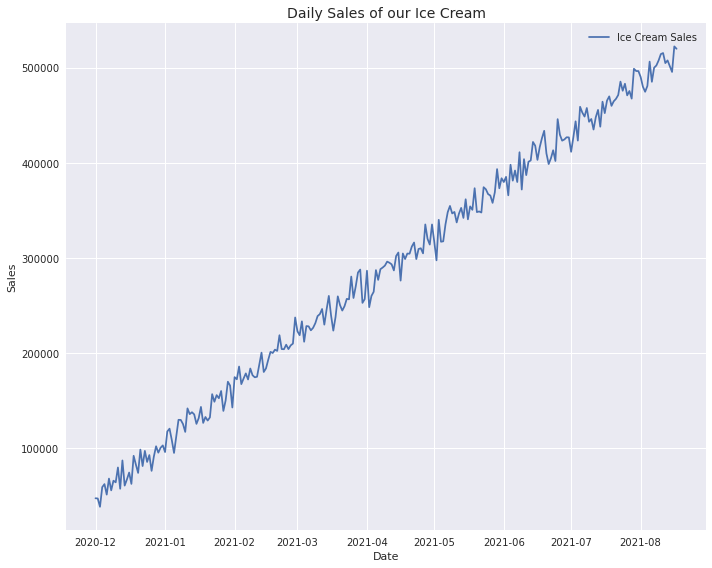

In [8]:
plot_single_series(augmented, 'Total_Sales', 'Ice Cream Sales', 'Sales', 'Daily Sales of our Ice Cream', 
                   'overall_sales')

#### Image generation for figure 12.5 RFM Histograms

In [9]:
recency = np.random.pareto(100, 500) * 1000
monetary = np.random.normal(10000, 500, 500) + (np.random.pareto(1000, 500) * 200000 )
frequency = np.random.pareto(100, 500) * 500

def get_ntiles(series, name):
    NtilePayload = namedtuple('NTiles', 'series p20 p40 p60 p80')
    return NtilePayload(
        name,
        np.percentile(series, 20),
        np.percentile(series, 40),
        np.percentile(series, 60),
        np.percentile(series, 80)
    )

def get_next_range(pre, current):
    return pre + current

def plot_distribution_rfm(series, series_name, figsize=(10,6)):
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=figsize)
        f_ntile = get_ntiles(series, series_name)
        ax = plt.hist(series, facecolor='0.4', bins=80)
        xmin, xmax, ymin, ymax = plt.axis()
        colors = ['blue', 'green', 'yellow', 'orange', 'red']
        if series_name == 'recency':
            colors.reverse()
        plt.axvspan(max(0, xmin), f_ntile.p20, ymin, ymax, facecolor=colors[0], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p20, f_ntile.p40, ymin, ymax, facecolor=colors[1], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p40, f_ntile.p60, ymin, ymax, facecolor=colors[2], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p60, f_ntile.p80, ymin, ymax, facecolor=colors[3], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p80, xmax, ymin, ymax, facecolor=colors[4], alpha=0.5, zorder=-100)
        plt.title("Distribution of {}".format(series_name))
        if series_name == 'recency':
            plt.xlabel("Days since last purchase")
        elif series_name == 'frequency':
            plt.xlabel("Frequency of purchases")
        else:
            plt.xlabel("Total Lifetime Spend")
        plt.ylabel("Customer count")
        plt.tight_layout()
        plt.savefig('rfm_{}.svg'.format(series_name), format='svg')

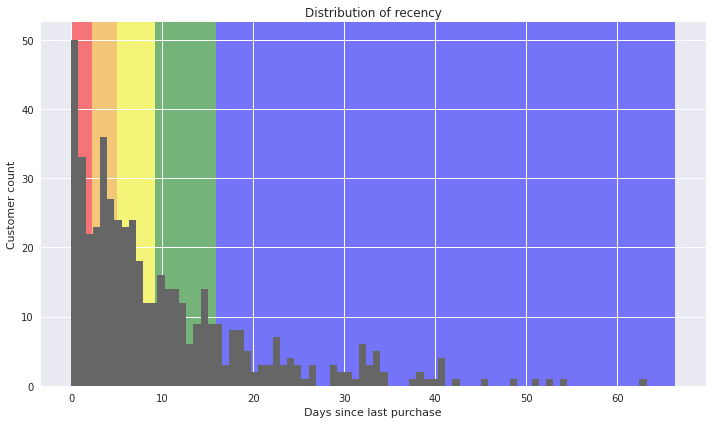

In [10]:
plot_distribution_rfm(recency, 'recency')

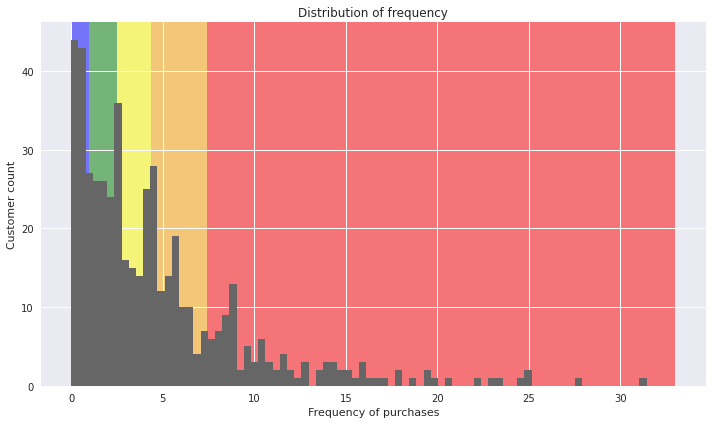

In [11]:
plot_distribution_rfm(frequency, 'frequency')

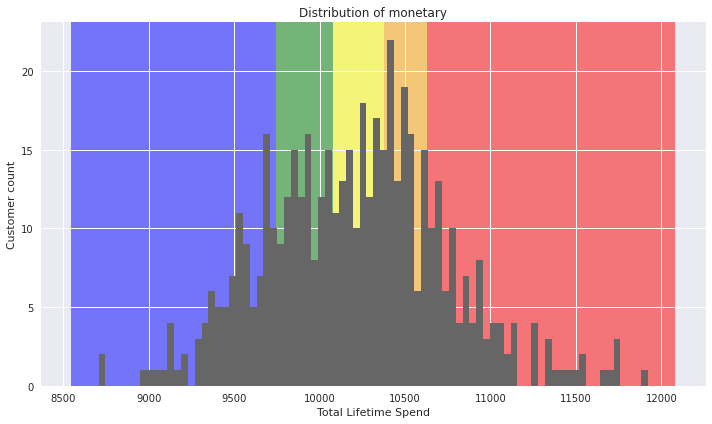

In [12]:
plot_distribution_rfm(monetary, 'monetary')

#### Plot generation for figure 12.6 Equivalency testing (multivariate) with ANOVA and Kruskal

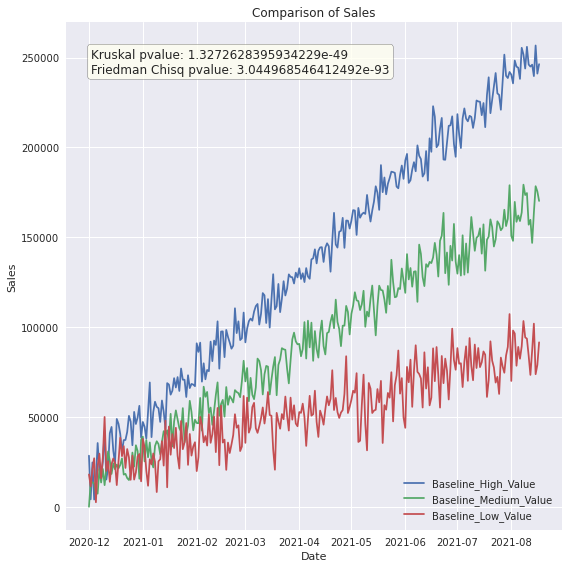

In [13]:
anova_data = generate_data(config_baseline)
plot_equivalency_series(date_ranges, anova_data, 'baseline', (8,8))

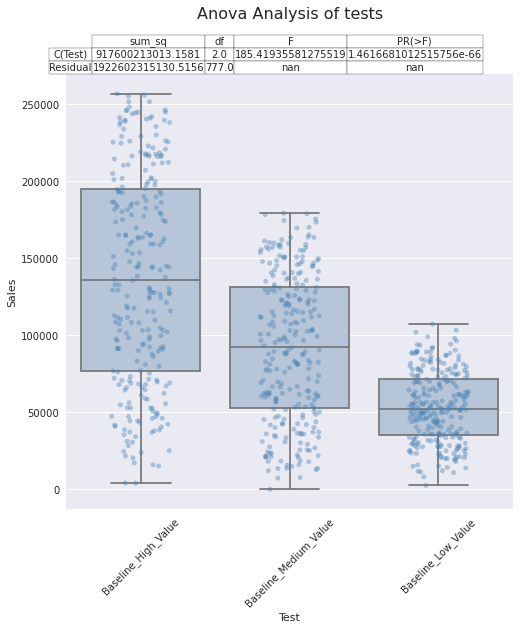

In [14]:
plot_anova(generate_melted_df(anova_data, date_ranges, 300), 'baseline', (8,8))

#### Plot generation for figures 12.7 and 12.8 Correlation and Causality

In [15]:
augmented['temperature'] = temperature

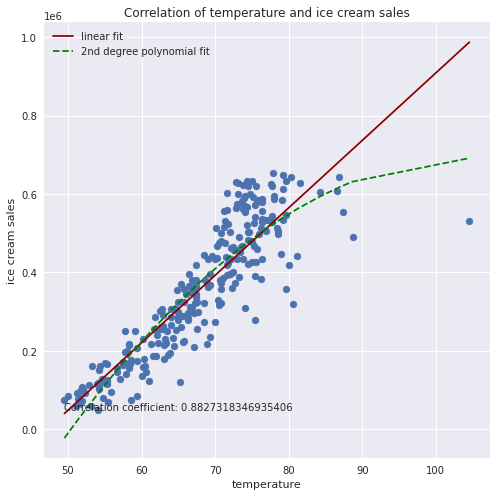

In [16]:
plot_corr(augmented['temperature'], augmented['Total_Sales'], 'temperature', 'ice cream sales', (7,7))

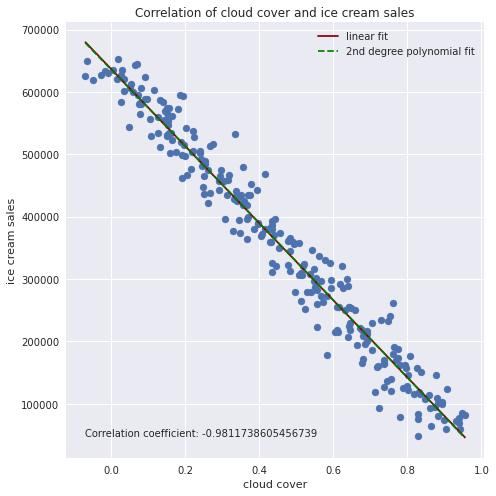

In [17]:
_base_clouds = np.random.normal(0.0, 0.05, DATA_SIZE)
cloud_cover = np.linspace(start=0.0, stop=0.9, num=DATA_SIZE)[::-1] + _base_clouds
augmented['cloud_cover'] = cloud_cover
plot_corr(augmented['cloud_cover'], augmented['Total_Sales'], 'cloud cover', 'ice cream sales', (7,7))

Which of these drives the signal more? Can we definitively say, based on the construction of a model, which of these highly correlated values is more of the cause associated with sales rising? <br>
No, we cannot. There is obviously a relationship to both temperature and cloud cover in the summer. But to understand the linked relationship, pairwise correlation analysis is not going to tell the whole story. Furthermore, we have no idea what other factors drive the decision to buy ice cream on any given day. <br>
We can determine correlation with these observations, but not causality.

#### Listing 12.1 and figure 12.10 
In this section, we're looking at a common method for estimating the number of events that we need in order to have sufficient data to make a determination of statistical significance. As part of this function, we have application-specific settings that can be modified (that are directly related to the type of problem that is being tested). 
As an example, we're going to look at a target revenue delta of 5% and an alpha of 0.2, utilizing a power value (1- probability of a type II error).
This example for sample size determination relies on normally distributed data sets for testing.

In [18]:
effect_size = tt_ind_solve_power(effect_size=0.1, nobs1=None, alpha=0.2, power=0.8, ratio=1, alternative='two-sided')
effect_size

900.9754880790556

To make this a bit more clear about the sample sizes, let's take a look at what would happen if we were expecting a very large difference between the means of the control and test groups. Instead of a 5% difference (which requires a large amount of data), what if we had a 25% lift in revenue? Let's map out the sample size estimation for significance with a varying amount of effects...

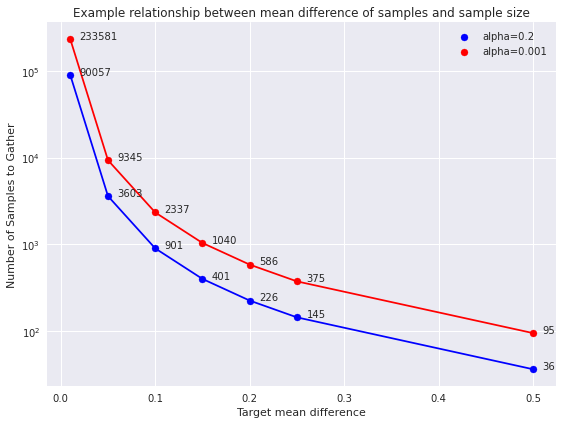

In [19]:
x_effects = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]
sample_sizes = [tt_ind_solve_power(x, None, 0.2, 0.8, 1, 'two-sided') for x in x_effects]
sample_sizes_low_alpha = [tt_ind_solve_power(x, None, 0.01, 0.8, 1, 'two-sided') for x in x_effects]

with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.plot(x_effects, sample_sizes, color='blue')
    plt.scatter(x_effects, sample_sizes, label='alpha=0.2', color='blue')
    ax1 = plt.plot(x_effects, sample_sizes_low_alpha, color='red')
    plt.scatter(x_effects, sample_sizes_low_alpha, label = 'alpha=0.001', color='red')
    plt.yscale('log')
    plt.legend(loc='best')
    for i, v in enumerate(sample_sizes):
        plt.annotate(np.round(v,0).astype(int), (x_effects[i] + 0.01, v))
    for i, v in enumerate(sample_sizes_low_alpha):
        plt.annotate(np.round(v,0).astype(int), (x_effects[i] + 0.01, v))
    plt.ylabel('Number of Samples to Gather')
    plt.xlabel('Target mean difference')
    plt.title("Example relationship between mean difference of samples and sample size")
    plt.tight_layout()
    plt.savefig('sample_sizes.svg', format='svg')

#### Figure 12.11 plot element

In [20]:
filter_aug_start = filter_augmented_start(augmented, 7)

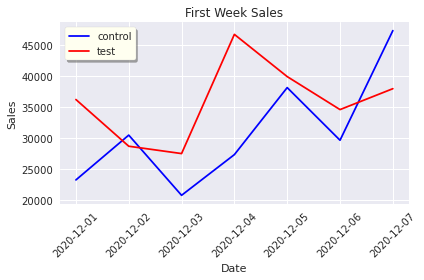

In [21]:
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax.plot(filter_aug_start['Date'], filter_aug_start['Control_Sales'], color='blue', label='control')
    ax.plot(filter_aug_start['Date'], filter_aug_start['Test_Sales'], color='red', label='test')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.xticks(rotation=45)
    ax.set_title("First Week Sales")
    legend = ax.legend(loc='best', shadow=True, frameon=True)
    legend.get_frame().set_facecolor('ivory')
    plt.tight_layout()
    plt.savefig('first_week_sales.svg', format='svg')

#### Figure 2.12 distribution plot generation

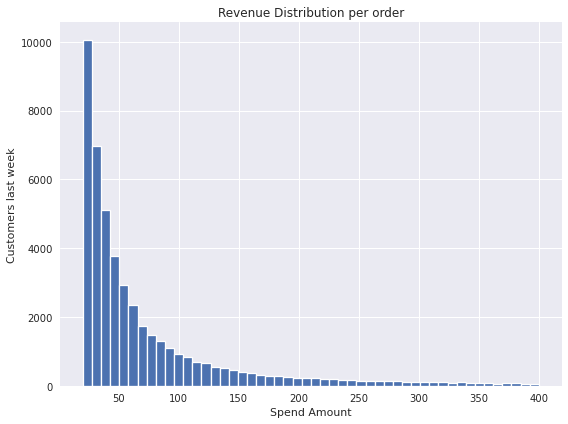

In [22]:
raw_revenue_typical = np.abs(np.random.standard_cauchy(100000))
revenue_typical = raw_revenue_typical[(raw_revenue_typical > 1) & (raw_revenue_typical < 20)] * 20

with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.hist(revenue_typical, linewidth=1.3, edgecolor='white', bins=50)
    ax.set_xlabel('Spend Amount')
    ax.set_ylabel('Customers last week')
    ax.set_title('Revenue Distribution per order')
    plt.tight_layout()
    plt.savefig('typical_revenue_distribution.svg', format='svg')

#### Figure 12.13 plot generation
Code for executing this is in the 'plotting section' at the top of this notebook.

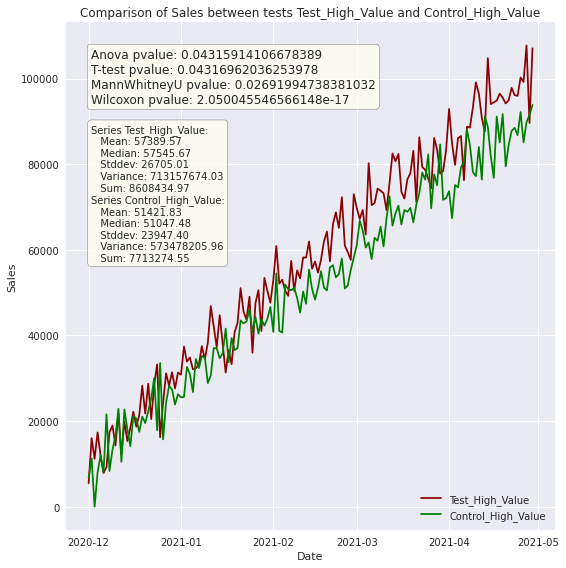

In [23]:
first_150 = filter_augmented_start(augmented, 150)
plot_comparison_series_df(
    first_150['Date'], 
    first_150['Test_High_Value'], 
    first_150['Control_High_Value'], 
    'first_150', (8,8))

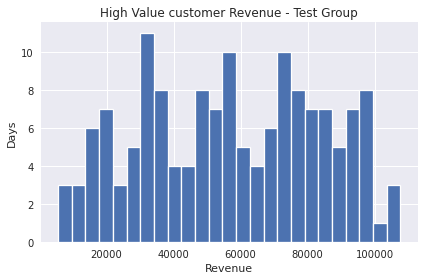

In [24]:
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax.hist(first_150['Test_High_Value'], linewidth=1.3, edgecolor='white', bins=25)
    ax.set_xlabel('Revenue')
    ax.set_ylabel('Days')
    ax.set_title('High Value customer Revenue - Test Group')
    plt.tight_layout()
    plt.savefig('first_150_dist.svg', format='svg')

#### Figure 12.14 ANOVA and distribution plot of stationary data

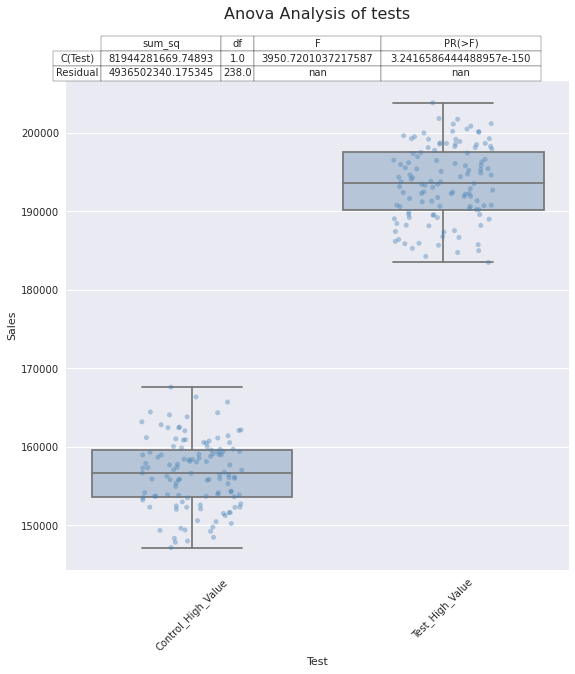

In [25]:
stationary_series_anova = generate_data(config_stationary_anova)
stationary_data_anova = generate_df(stationary_series_anova, date_ranges)
plot_anova(generate_melted_df(stationary_series_anova, date_ranges, 120), 'stationary_120', (9,9))

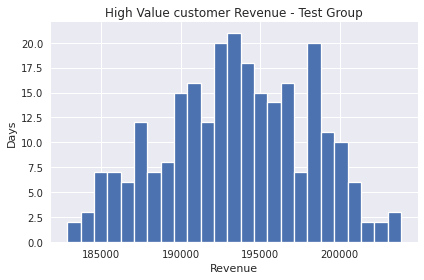

In [26]:
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax.hist(stationary_data_anova['Test_High_Value'], linewidth=1.3, edgecolor='white', bins=25)
    ax.set_xlabel('Revenue')
    ax.set_ylabel('Days')
    ax.set_title('High Value customer Revenue - Test Group')
    plt.tight_layout()
    plt.savefig('stationary_hv_dist.svg', format='svg')

#### Figure 12.15 Plot generation

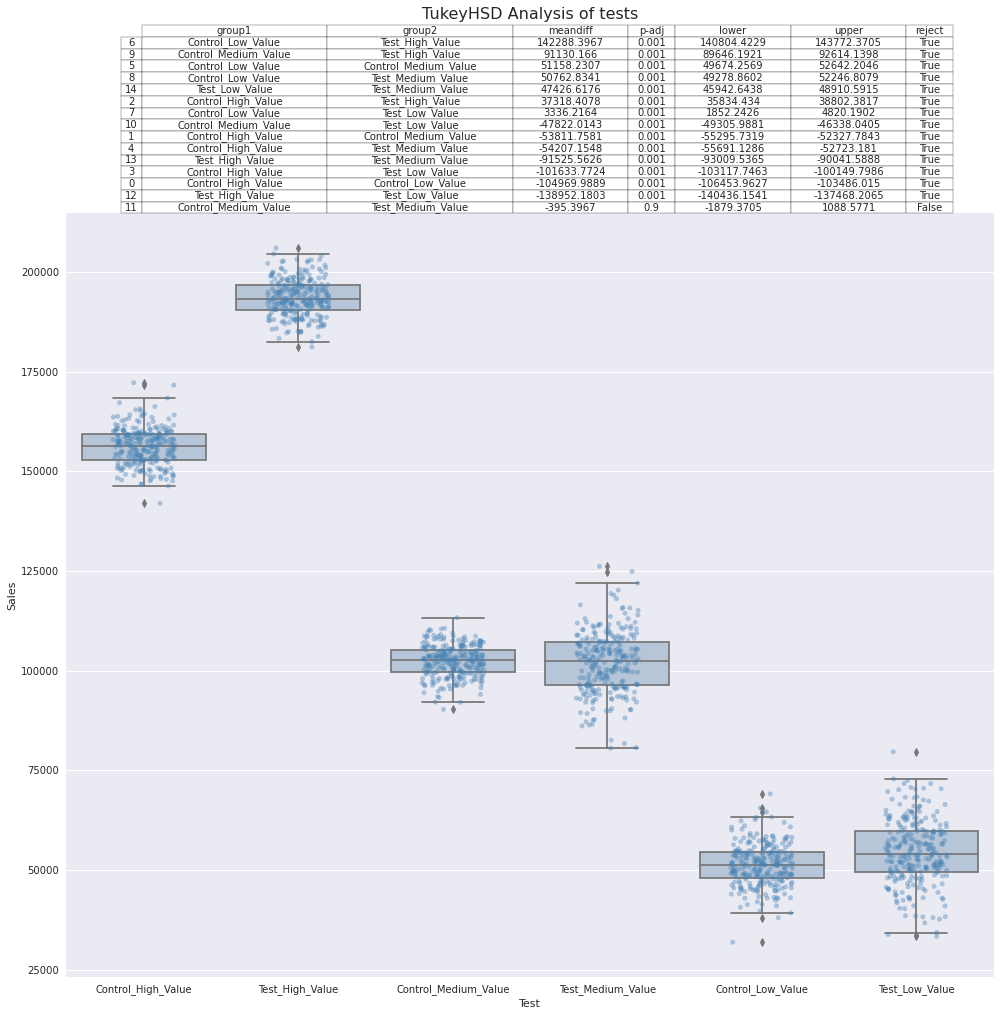

In [27]:
stationary_melted = generate_melted_df(generate_data(config_stationary), date_ranges)
plot_tukey(stationary_melted, 'stationary_full')

#### Listing 12.5 and Figure 12.16 plot

Define the configuration to generate the nominal data set

In [28]:
COUPONS_ISSUED = 50000
TEST_ISSUED = 25000
CONTROL_ISSUED = COUPONS_ISSUED - TEST_ISSUED
COUPON_DATES = 50
_lin_factor_control = np.linspace(start=0, stop=5000, num=COUPON_DATES).astype(int)
_lin_factor_test = np.linspace(start=0, stop=10000, num=COUPON_DATES).astype(int)
control_series = np.random.uniform(low=1000, high=10000, size=COUPON_DATES).astype(int) + _lin_factor_control
control_unused = [CONTROL_ISSUED - x for x in control_series]
test_series = np.random.uniform(low=2000, high=10000, size=COUPON_DATES).astype(int) + _lin_factor_test
test_unused = [TEST_ISSUED - x for x in test_series]
used_series = control_series + test_series
unused_series = [COUPONS_ISSUED - x for x in used_series]

In [29]:
def categorical_significance(test_happen, test_not_happen, control_happen, control_not_happen):
    CategoricalTest = namedtuple('CategoricalTest', 
                                 'fisher_stat fisher_p chisq_stat chisq_p chisq_df chisq_expected')
    t_happen = np.sum(test_happen)
    t_not_happen = np.sum(test_not_happen)
    c_happen = np.sum(control_happen)
    c_not_happen = np.sum(control_not_happen)
    matrix = np.array([[t_happen, c_happen], [t_not_happen, c_not_happen]])
    fisher_stat, fisher_p = fisher_exact(matrix)
    chisq_stat, chisq_p, chisq_df, chisq_expected = chi2_contingency(matrix)
    return CategoricalTest(fisher_stat, fisher_p, chisq_stat, chisq_p, chisq_df, chisq_expected)

def plot_coupon_usage(test_happen, test_not_happen, control_happen, control_not_happen, name, figsize=(10,8)):
    cat_test = categorical_significance(test_series, test_unused, control_series, control_unused)
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        dates = np.arange(DATE_START, 
                            DATE_START + timedelta(days=COUPON_DATES), 
                            timedelta(days=1)).astype(date)
        bar1 = ax.bar(dates, test_series, color='#5499C7', label='Test Coupons Used')
        bar2 = ax.bar(dates, test_unused, bottom=test_series, color='#A9CCE3', label='Test Unused Coupons')
        bar3 = ax.bar(dates, control_series, bottom=test_series+test_unused, color='#52BE80', 
                      label='Control Coupons Used')
        bar4 = ax.bar(dates, control_unused, bottom=test_series+test_unused+control_series, 
                      color='#A9DFBF', label='Control Unused Coupons')
        bbox_text = "Fisher's Exact pvalue: {}\nChisq Contingency pvalue: {}\nChisq DF: {}".format(
                cat_test.fisher_p, cat_test.chisq_p, cat_test.chisq_df
            )
        bbox_props = dict(boxstyle='round', facecolor='ivory', alpha=1.0)
        ax.set_title("Coupon Usage Comparison", fontsize=16)
        ax.text(0.05, 0.95, bbox_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=bbox_props)
        ax.set_xlabel('Date')
        ax.set_ylabel('Coupon Usage')
        legend = ax.legend(loc='best', shadow=True, frameon=True)
        legend.get_frame().set_facecolor('ivory')
        plt.tight_layout()
        plt.savefig('coupon_usage_{}.svg'.format(name), format='svg')

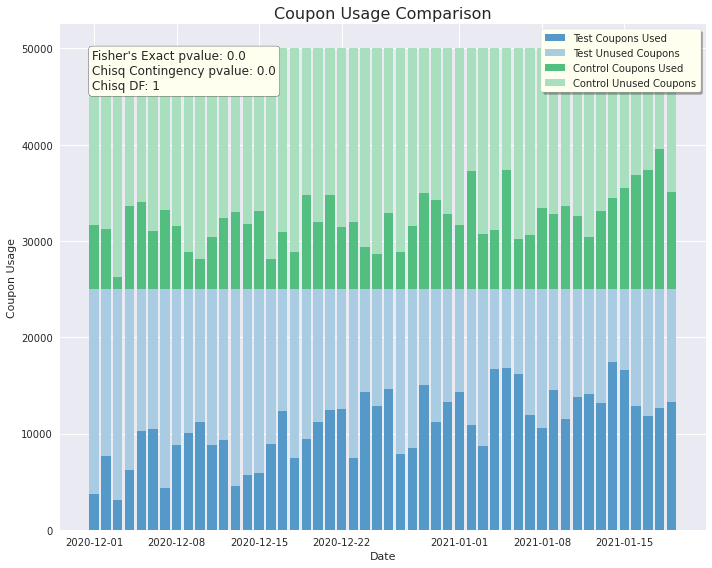

In [30]:
plot_coupon_usage(test_series, test_unused, control_series, control_unused, '50days')

#### Figure 12.17 Feature Drift

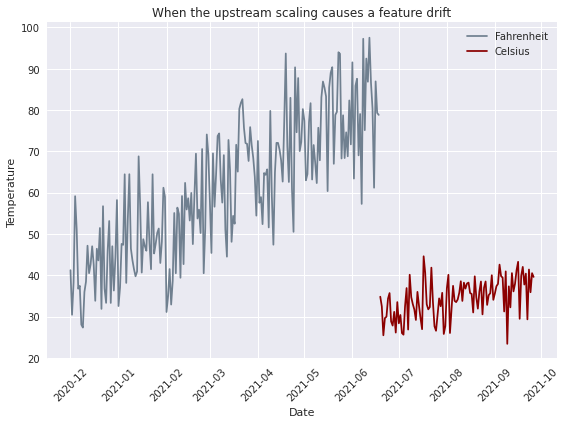

In [31]:
change_dates = datetime(2020,12,1)
date_ranges_f = np.arange(change_dates, 
                        change_dates + timedelta(days=200), 
                        timedelta(days=1)).astype(date)
change_threshold = datetime(2021, 6, 19)
date_ranges_c = np.arange(change_threshold, 
                        change_threshold + timedelta(days=100), 
                        timedelta(days=1)).astype(date)
begin_raw = np.linspace(35, 85, 200) + np.random.normal(loc=0, scale=10, size=200)
change_point_raw = np.linspace(85, 105, 100) + np.random.normal(loc=0, scale=8, size=100)
change_point = np.array([(x - 32) * (5/9) for x in change_point_raw])
begin = np.append(begin_raw, change_point)

with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.plot(date_ranges_f, begin[:200], color='slategrey', label='Fahrenheit')
    ax = plt.plot(date_ranges_c, begin[200:], color='darkred', label='Celsius')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title("When the upstream scaling causes a feature drift")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('temp_shift.svg', format='svg')

#### Figure 12.18 Prediction Drift

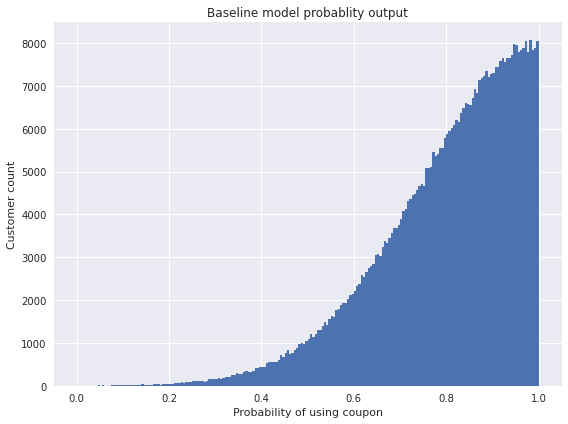

In [32]:
label_pre_raw = (1.0 - np.random.normal(loc=0.5, scale=0.25, size=1000000)) + 0.5
label_pre = label_pre_raw[label_pre_raw <= 1.0]
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.hist(label_pre, bins=200, range=[0.0, 1.0])
    plt.xlabel('Probability of using coupon')
    plt.ylabel('Customer count')
    plt.title('Baseline model probablity output')
    plt.tight_layout()
    plt.savefig('label_pre_drift.svg', format='svg')

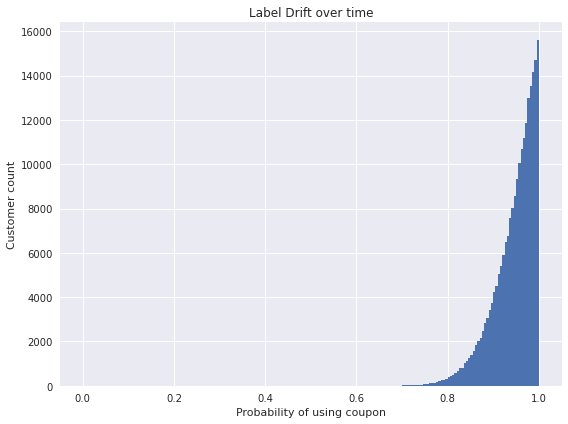

In [33]:
label_post_raw = (1.0 - np.random.normal(loc=0.9, scale=0.1, size=1200000))  + 0.99
label_post = label_post_raw[label_post_raw <= 1.0]
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.hist(label_post, bins=200, range=[0.0, 1.0])
    plt.xlabel('Probability of using coupon')
    plt.ylabel('Customer count')
    plt.title('Label Drift over time')
    plt.tight_layout()
    plt.savefig('label_drift.svg', format='svg')

#### Figure 12.20 Prediction Drift

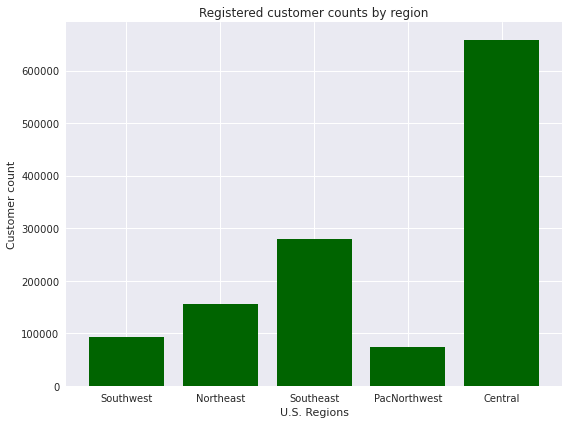

In [34]:
prior_region = {'Southwest': 92511, 'Northeast': 155123, 'Southeast': 278933, 
                'PacNorthwest': 73445, 'Central': 658743}
post_region = {'Southwest': 98511, 'Northeast': 179123, 'Southeast': 294933, 
                'PacNorthwest': 598739, 'Central': 698842}
region_size = range(len(prior_region))

with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.bar(region_size, list(prior_region.values()), align='center', color='darkgreen')
    plt.xticks(region_size, list(prior_region.keys()))
    plt.xlabel('U.S. Regions')
    plt.ylabel('Customer count')
    plt.title('Registered customer counts by region')
    plt.tight_layout()
    plt.savefig('customer_region_counts_pre.svg', format='svg')

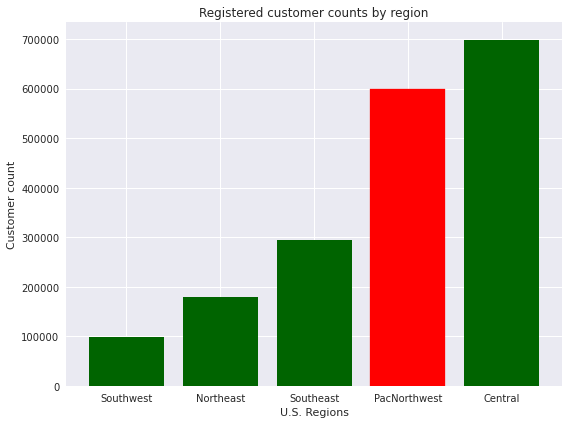

In [35]:
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.bar(region_size, list(post_region.values()), align='center', color='darkgreen')
    ax[3].set_color('r')
    plt.xticks(region_size, list(post_region.keys()))
    plt.xlabel('U.S. Regions')
    plt.ylabel('Customer count')
    plt.title('Registered customer counts by region')
    plt.tight_layout()
    plt.savefig('customer_region_counts_post.svg', format='svg')

#### Figure 12.21 Drift monitoring

In [36]:
full_dates = np.append(date_ranges_f, date_ranges_c)
temp_shift_df = pd.DataFrame(data=begin, columns=['temp'])
temp_shift_df['date'] = full_dates

def basic_shift_example(data, field, window=7, sigma=3):
    roll_mean = 'rolling_mean_{}'.format(field)
    roll_std = 'rolling_std_{}'.format(field)
    data[roll_mean] = data[field].rolling(window).mean()
    data[roll_std] = data[field].rolling(window).std()
    data['upper_bound_{}'.format(field)] = data[roll_mean] + (data[roll_std] * sigma)
    data['lower_bound_{}'.format(field)] = data[roll_mean] - (data[roll_std] * sigma)
    return data

def plot_basic_alert_chart(data, field, name, window=7, sigma=3, figsize=(8,7)):
    plotting_df = basic_shift_example(data, field, window, sigma)
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=figsize)
        ax = plt.plot(plotting_df['date'], plotting_df[field], color='slategrey', label=field)
        ax = plt.plot(plotting_df['date'], 
                      plotting_df['rolling_mean_{}'.format(field)], 
                      color='darkgreen', linestyle='--', label='Rolling Mean')
        ax = plt.plot(plotting_df['date'], 
                      plotting_df['upper_bound_{}'.format(field)], 
                      color='red', linestyle='-.', label='Boundaries')
        ax = plt.plot(plotting_df['date'], 
                      plotting_df['lower_bound_{}'.format(field)], 
                      color='red', linestyle='-.')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Temperature')
        plt.title("When the upstream scaling causes a feature drift")
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig('alerting_{}.svg'.format(field), format='svg')

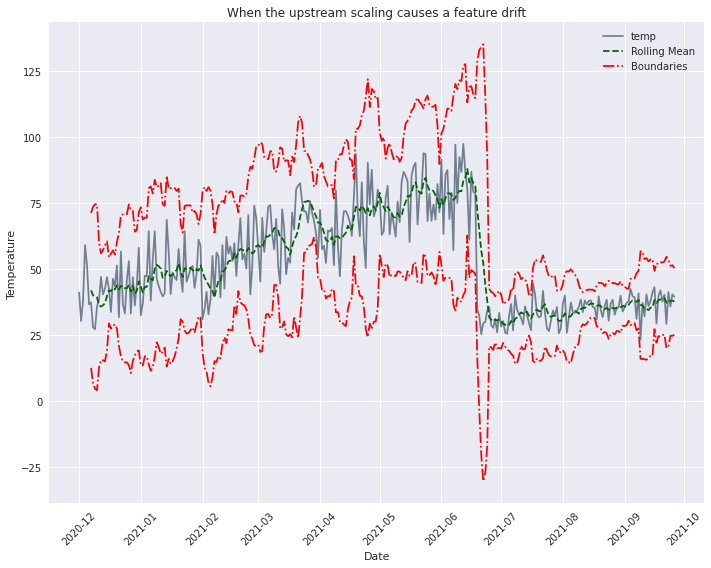

In [37]:
plot_basic_alert_chart(temp_shift_df, 'temp', 'temp_shift', 7, 3, (10,8))